# Лабораторная работа (часть первая)

В данной работе мы с вами попробуем применить рекуррентные сети к задаче предсказания цены акций компании Microsoft.

В данном ноутбуке вы найдете частично готовый к применению код, некоторые элементы которого пропущены и вместо них стоит заглушка "\<ENTER YOUR CODE HERE>". Это означает, что вместо этой заглушки вам необходимо написать собственный код, решающий какую-то конкретную подзадачу. Детали вы найдете в комментариях около каждого из таких мест. 
    
Давайте убедимся, что у нас установлены все необходимые библиотеки.

In [323]:
#!pip install numpy matplotlib tensorflow

Для воспроизводимости зафиксируем генераторы случайных чисел.

In [324]:
seed_value= 0

import os
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

Импортируем все необходимые библиотеки.

In [325]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

Для начала нам необходимо прочитать набор данных. Вместе с данным ноутбуком вы найдете файл MSFT_corrupted.csv. Прочитайте и запишите его в фрейм.

In [326]:
df_dirty = pd.read_csv('MSFT_corrupted.csv', sep=',')

Давайте выведем первые несколько строк файла.

In [327]:
df_dirty.head()

,date,open,high,low,close,volume,Name
0,2015-11-18,53.00,53.98,52.9799,53.85,29710030,MSFT
1,2015-11-19,53.99,54.66,53.7810,53.94,28149228,MSFT
2,2015-11-20,54.25,54.30,53.2650,54.19,37147608,MSFT
3,2015-11-23,54.25,54.46,53.7500,54.19,28235918,MSFT
4,2015-11-24,53.92,54.44,53.5800,54.25,24600043,MSFT


Судя по названию файла, в нем могут присутствовать проблемы с данными. Давайте проверим данные на наличие NaN и каким-либо образом восстановим пропущенные значения.

In [328]:
print(pd.isna(df_dirty).sum())   # Смотрим, есть ли NaN
df = df_dirty.dropna()     # Если есть - избавляемся от них.
print(pd.isna(df).sum())

date      0
open      5
high      5
low       5
close     5
volume    0
Name      0
dtype: int64
date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64


В данной работе мы с вами будем предсказывать стоимость акции на момент закрытия дня (колонка 'close'). Давайте построим график этой колонки.

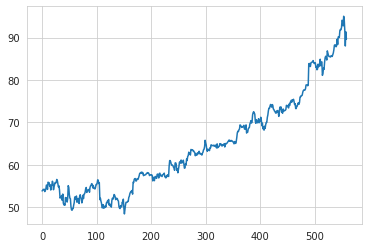

In [329]:
df['close'].plot()

Оставим в нашем датафрейме только необходимую нам колонку.

In [330]:
train_df = df['close']
train_df = train_df.to_frame(name = 'close')
train_df.shape

(554, 1)

Итак, теперь давайте подготовим все необходимое для начала обучения. Зададим глобальные константы - количества эпох, дней и коэффициент деления массива.

In [331]:
EPOCHS = 10  # количество эпох для обучения
DAYS = 10    # на сколько дней назад смотреть при обучении
SPLIT_VALUE = 0.95  # как делить массив

Определим константу для разделения массива на тренировочную и тестовую части.

In [332]:
training_data_len = int(len(train_df) * SPLIT_VALUE)
training_data_len

526

Далее с помощью MinMaxScaler'а приведем данные к значениям на отрезке \[0, 1]

In [333]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_df)

Давайте создадим тренировочный набор данных. Набор будет выглядеть следующим образом: мы будем брать данные за последние X дней и формировать из этого вектор X, а вектор Y будет являться значением стоимости акции на следующий день

In [334]:
import reprlib
train_data = scaled_data[:training_data_len, :]

x_train = []
y_train = []

for i in range(DAYS, len(train_data)):
    x_train.append(train_data[i-DAYS:i])
    y_train.append(train_data[i, 0])    

x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, reprlib.repr(x_train), y_train.shape, reprlib.repr(y_train)

((516, 10, 1),
 'array([[[0.11...0.79368828]]])',
 (516,),
 'array([0.1238...  0.8003435 ])')

Создадим модель для предсказания. Первым слоем модели должен являться рекуррентный слой с соответствующей формой входного тензора, последним - полносвязный слой с единственным нейроном для предсказания результата.

In [335]:
model = Sequential()
model.add(LSTM(units = 16, input_shape = (DAYS, 1), activation = 'linear'))
model.add(Dense(8, activation = 'relu')) 
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [336]:
model.fit(x_train, y_train, batch_size=1, epochs=EPOCHS)

Epoch 1/10
516/516 [==============================] - 3s 4ms/step - loss: 0.0066
Epoch 2/10
516/516 [==============================] - 2s 4ms/step - loss: 8.6798e-04
Epoch 3/10
516/516 [==============================] - 2s 4ms/step - loss: 8.5428e-04
Epoch 4/10
516/516 [==============================] - 2s 4ms/step - loss: 6.6135e-04
Epoch 5/10
516/516 [==============================] - 2s 4ms/step - loss: 6.4170e-04
Epoch 6/10
516/516 [==============================] - 2s 4ms/step - loss: 6.6692e-04
Epoch 7/10
516/516 [==============================] - 2s 4ms/step - loss: 6.7860e-04
Epoch 8/10
516/516 [==============================] - 2s 4ms/step - loss: 5.8181e-04
Epoch 9/10
516/516 [==============================] - 2s 4ms/step - loss: 5.4290e-04
Epoch 10/10
516/516 [==============================] - 2s 4ms/step - loss: 5.7944e-04


Для тестирования нашей модели давайте таким же образом сформируем тестовый датасет.

In [337]:
test_data = scaled_data[training_data_len - DAYS: , :]

x_test = []
y_test = []
for i in range(DAYS, len(test_data)):
    x_test.append(test_data[i-DAYS:i])
    y_test.append(test_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, reprlib.repr(x_test), y_test.shape, reprlib.repr(y_test)

((28, 10, 1),
 'array([[[0.79...0.92099614]]])',
 (28,),
 'array([0.8005..., 0.88407042])')

Давайте получим предсказания модели и визуализируем результат.

In [338]:
predictions = model.predict(x_test)

1/1 [==============================] - 0s 212ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


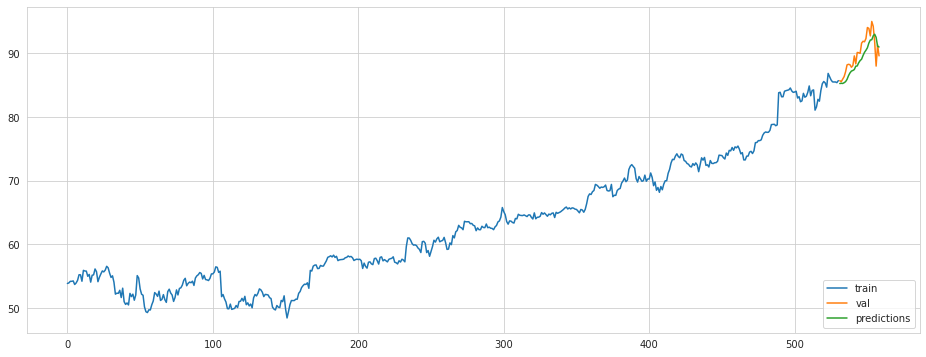

In [339]:
train = train_df[:training_data_len]
valid = train_df[training_data_len:]
valid['predictions'] = scaler.inverse_transform(predictions)
plt.figure(figsize=(16,6))
plt.plot(train['close'])
plt.plot(valid[['close', 'predictions']])
plt.legend(['train', 'val', 'predictions'], loc='lower right')

В качестве бейзлайна (т.е. базовой просто модели для сравнения) выберем step-1 модель. Данная модель для дня i просто берет значение дня i-1. Реализуйте такую модель и в массив prediction_step запишите ее результаты для тех же данных.

In [340]:
predictions = scaler.inverse_transform(predictions)
predictions_step = [predictions[0][0]]
for predict in predictions[:-1]:
  predictions_step.append(predict[0])

predictions_step = np.array(predictions_step).reshape(len(predictions_step), 1)
predictions_step[:5]

array([[85.25981],
       [85.25981],
       [85.29617],
       [85.27271],
       [85.3861 ]], dtype=float32)

In [341]:
assert predictions.shape == predictions_step.shape

Построим график нашей модели и step-1 модели.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


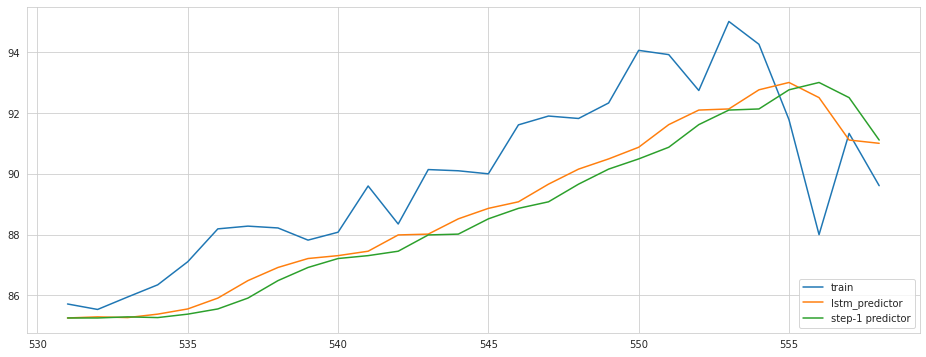

In [342]:
valid['predictions_step'] = predictions_step
plt.figure(figsize=(16,6))
plt.plot(valid[['close', 'predictions', 'predictions_step']])
plt.legend(['train', 'lstm_predictor', 'step-1 predictor'], loc='lower right')

Удалось ли вам добиться хороших результатов модели? Попробуйте поменять модель нейронной сети, количество слоев, и другие гиперпараметры.  

В процессе тестирования нашей модели мы, тем не менее, использовали "настоящие" данные каждый день для предсказания следующего дня. Давайте попробуем предсказать `len(valid)` дней (т.е. столько же, какова длина массива тестирования) обладая лишь данными на момент дня начала тестирования.  

Т.е. каждый шаг алгоритму необходимо подавать данные за последние DAYS дней, получать его предсказание и записывать в массив с данными как результат дня $i$. На следующем шаге в качестве данных уже будут данные за последние DAYS-1 дней и день $i$, а результат будет записан в день $i+1$ и так далее. Конечным итогом станет то, что мы сможем предсказать движение акций на несколько дней вперед.

In [343]:
x_test_independent = y_test[0]  # взять данные за первый день тестового периода
for i in range(len(valid)):
    result = model.predict(x_test_independent.reshape((1,i+1, 1)))   # Получить предсказание модели на данных
    x_test_independent = np.append(x_test_independent, result)  # Добавить полученный result в конец массива x_test_independent, т.о. он будет использован в следующий раз

1/1 [==============================] - 0s 26ms/step


Давайте построим график и посмотрим на результат, а также сравним его с результатом, когда нам известна настоящая информация за указанные дни.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


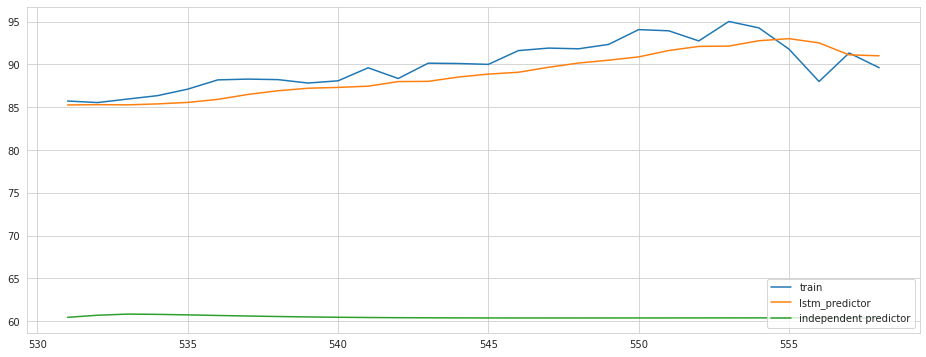

In [344]:
valid['predictions_indep'] = scaler.inverse_transform(x_test_independent.reshape((-1, 1)))[-len(valid):]
plt.figure(figsize=(16,6))
plt.plot(valid[['close', 'predictions', 'predictions_indep']])
plt.legend(['train', 'lstm_predictor', 'independent predictor'], loc='lower right')

Как можно заметить, результат оставляет желать лучшего. Рекуррентные модели склонны не учитывать тренд и фиксироваться на какой-либо точке.

# Вторая часть

Вашим дальнейшим заданием будет следующее.  
В процессе анализа стоимости акций важным параметром является Moving Average - средняя стоимость акций за последние N дней. Вам необходимо вычислить MA за последние 7, 14 и 28 дней и добавить их как отдельные столбцы к тренировочным данным. После чего - натренировать новую нейронную сеть, которая будет получать MA 7, 14, 28 как входные данные и пытаться предсказывать их значения. 

В конце точно так же сравните полученный результат с step-1 моделью и попробуйте построить предсказания из единственной точки. Сможет ли Moving Average исправить проблемы тренда за счет более гладких и усредненных результатов?

In [345]:
df

,date,open,high,low,close,volume,Name
0,2015-11-18,53.00,53.980,52.9799,53.85,29710030,MSFT
1,2015-11-19,53.99,54.660,53.7810,53.94,28149228,MSFT
2,2015-11-20,54.25,54.300,53.2650,54.19,37147608,MSFT
3,2015-11-23,54.25,54.460,53.7500,54.19,28235918,MSFT
4,2015-11-24,53.92,54.440,53.5800,54.25,24600043,MSFT
...,...,...,...,...,...,...,...
554,2018-02-01,94.79,96.070,93.5813,94.26,47227882,MSFT
555,2018-02-02,93.64,93.970,91.5000,91.78,47867753,MSFT
556,2018-02-05,90.56,93.240,88.0000,88.00,51031465,MSFT
557,2018-02-06,86.89,91.475,85.2500,91.33,67998564,MSFT


In [346]:
df["MA_7"] = list(df["close"])
df["MA_14"] = list(df["close"])
df["MA_28"] = list(df["close"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [347]:
for (i, j) in [(7,"MA_7"), (14,"MA_14"), (28,"MA_28")]:
  for k in range(i, 559):
    df[j][k] = np.mean(df['close'][k-i:k])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


In [348]:
train_df = df[['MA_7', 'MA_14', 'MA_28']]
#train_df = df[['MA_7']]
train_df[:5]

,MA_7,MA_14,MA_28
0,53.85,53.85,53.85
1,53.94,53.94,53.94
2,54.19,54.19,54.19
3,54.19,54.19,54.19
4,54.25,54.25,54.25


In [349]:
training_data_len = int(len(train_df) * SPLIT_VALUE)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_df)

In [350]:
train_data = scaled_data[:training_data_len, :]

x_train = []
y_train = []

for i in range(DAYS, len(train_data)):
    x_train.append(train_data[i-DAYS:i])
    y_train.append(train_data[i,0])    

x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, reprlib.repr(x_train), y_train.shape, reprlib.repr(y_train)

((516, 10, 3),
 'array([[[0.08...0.84376129]]])',
 (516,),
 'array([0.1018...  0.82267499])')

In [351]:
model = Sequential()
model.add(LSTM(units = 16, input_shape = (DAYS, 3), activation = 'linear'))
model.add(Dense(8, activation = 'relu')) 
model.add(Dense(3))

model.compile(optimizer='adam', loss='mean_squared_error')

In [352]:
model.fit(x_train, y_train, batch_size=1, epochs=EPOCHS)

Epoch 1/10
516/516 [==============================] - 3s 4ms/step - loss: 0.0072
Epoch 2/10
516/516 [==============================] - 2s 4ms/step - loss: 8.1605e-04
Epoch 3/10
516/516 [==============================] - 2s 4ms/step - loss: 6.8489e-04
Epoch 4/10
516/516 [==============================] - 2s 4ms/step - loss: 6.0533e-04
Epoch 5/10
516/516 [==============================] - 2s 4ms/step - loss: 6.0796e-04
Epoch 6/10
516/516 [==============================] - 2s 4ms/step - loss: 5.2482e-04
Epoch 7/10
516/516 [==============================] - 2s 4ms/step - loss: 4.7962e-04
Epoch 8/10
516/516 [==============================] - 2s 4ms/step - loss: 4.6510e-04
Epoch 9/10
516/516 [==============================] - 2s 4ms/step - loss: 3.7880e-04
Epoch 10/10
516/516 [==============================] - 2s 4ms/step - loss: 3.5348e-04


In [353]:
test_data = scaled_data[training_data_len - DAYS: , :]

x_test = []
y_test = []
for i in range(DAYS, len(test_data)):
    x_test.append(test_data[i-DAYS:i])
    y_test.append(test_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test.shape, reprlib.repr(x_test), y_test.shape, reprlib.repr(y_test)

((28, 10, 3),
 'array([[[0.80...0.99570749]]])',
 (28,),
 'array([0.8279..., 0.91254245])')

In [354]:
predictions = model.predict(x_test)

1/1 [==============================] - 0s 181ms/step


In [355]:
scaler.inverse_transform(predictions.reshape(28, 3))[:,0]

array([84.55167 , 84.67134 , 84.86349 , 85.098656, 85.34319 , 85.58479 ,
       85.82454 , 86.10628 , 86.34023 , 86.58642 , 86.83038 , 87.07234 ,
       87.39593 , 87.770454, 88.121956, 88.514915, 88.9333  , 89.36217 ,
       89.746925, 90.1475  , 90.51455 , 90.75304 , 90.74662 , 90.65812 ,
       90.45102 , 90.307014, 90.07942 , 89.772804], dtype=float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


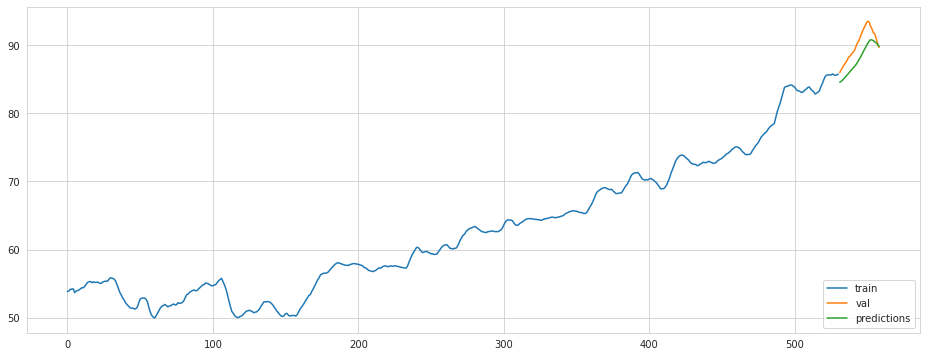

In [356]:
train = train_df[:training_data_len]
valid = train_df[training_data_len:]
valid['pred_MA_7'] = scaler.inverse_transform(predictions)[:,0]
plt.figure(figsize=(16,6))
plt.plot(train['MA_7'])
plt.plot(valid[['MA_7', 'pred_MA_7']])
plt.legend(['train', 'val', 'predictions'], loc='lower right')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


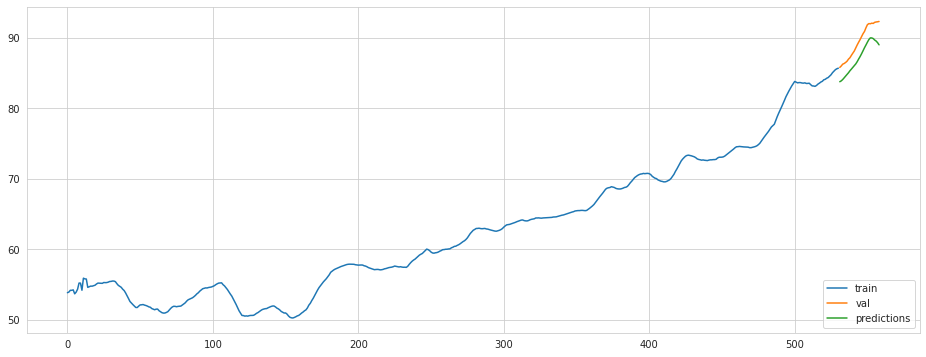

In [357]:
valid['pred_MA_14'] = scaler.inverse_transform(predictions)[:,1]
plt.figure(figsize=(16,6))
plt.plot(train['MA_14'])
plt.plot(valid[['MA_14', 'pred_MA_14']])
plt.legend(['train', 'val', 'predictions'], loc='lower right')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


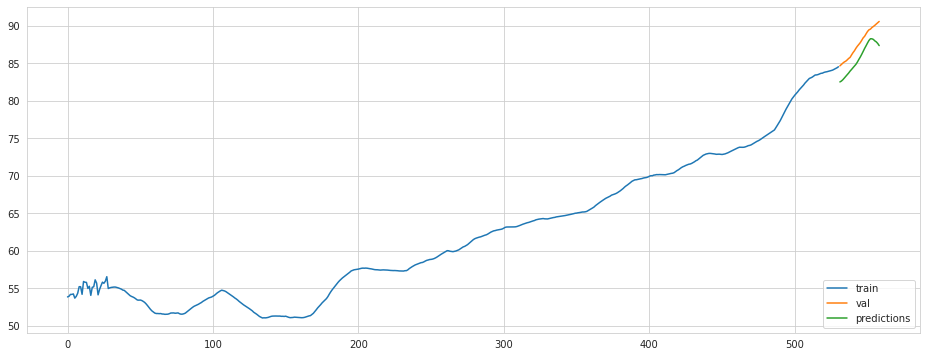

In [358]:
valid['pred_MA_28'] = scaler.inverse_transform(predictions)[:,2]
plt.figure(figsize=(16,6))
plt.plot(train['MA_28'])
plt.plot(valid[['MA_28', 'pred_MA_28']])
plt.legend(['train', 'val', 'predictions'], loc='lower right')

In [359]:
predictions = scaler.inverse_transform(predictions)
predictions_step = [predictions[0]]
for predict in predictions[:-1]:
  predictions_step.append(predict)

predictions_step = np.array(predictions_step).reshape(len(predictions_step), 3)
predictions_step[:5]

array([[84.55167 , 83.759575, 82.52946 ],
       [84.55167 , 83.759575, 82.52946 ],
       [84.67134 , 83.87951 , 82.6406  ],
       [84.86349 , 84.07207 , 82.819046],
       [85.098656, 84.30774 , 83.037445]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


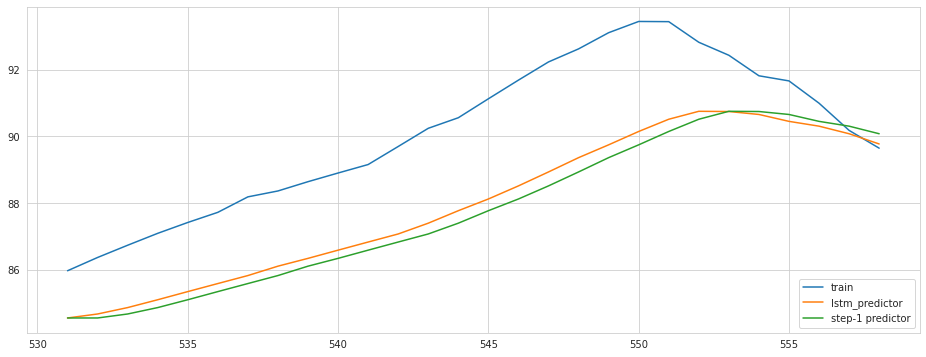

In [360]:
valid['predictions_step_MA_7'] = predictions_step[:,0]
plt.figure(figsize=(16,6))
plt.plot(valid[['MA_7', 'pred_MA_7', 'predictions_step_MA_7']])
plt.legend(['train', 'lstm_predictor', 'step-1 predictor'], loc='lower right')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


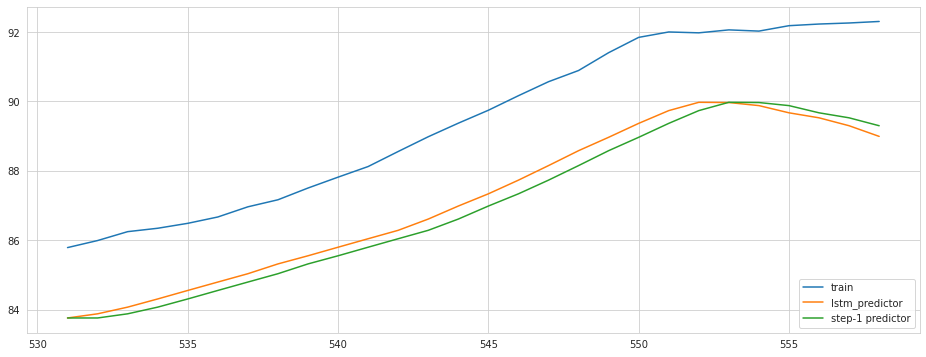

In [361]:
valid['predictions_step_MA_14'] = predictions_step[:,1]
plt.figure(figsize=(16,6))
plt.plot(valid[['MA_14', 'pred_MA_14', 'predictions_step_MA_14']])
plt.legend(['train', 'lstm_predictor', 'step-1 predictor'], loc='lower right')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


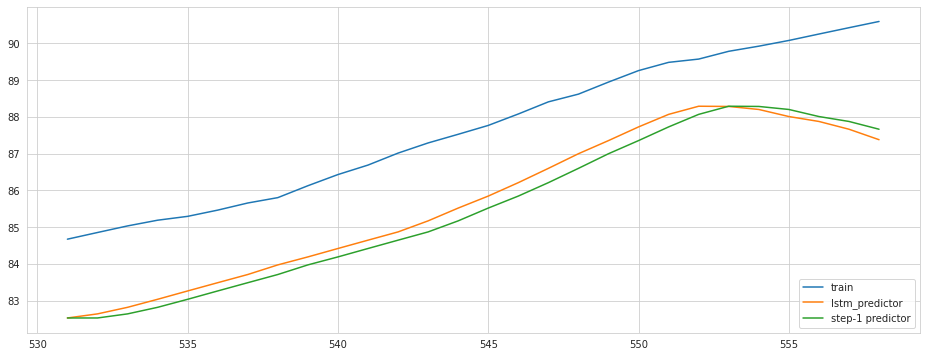

In [362]:
valid['predictions_step_MA_28'] = predictions_step[:,2]
plt.figure(figsize=(16,6))
plt.plot(valid[['MA_28', 'pred_MA_28', 'predictions_step_MA_28']])
plt.legend(['train', 'lstm_predictor', 'step-1 predictor'], loc='lower right')

**Вывод**: Moving Average заметно исправляет проблему!